
&nbsp;

#  The &nbsp; A C A &nbsp; l a b

&nbsp;

### A Jupyter Notebook laboratory for "Augmented" Cellular Automata"
### CSB195, Fall 2025

&nbsp;

---
## What is this?
**ACA Lab** is a hands-on notebook for exploring **elementary cellular automata (ECA)** and for *augmenting* them with your own interventions. You can run classic Wolfram rules (0–255), and add small pieces of code that modify how the system **looks** (appearance) or, if you choose, how it **evolves** (state). 

## What does it do?
- **Core engine (Python/NumPy):** evolves a 1-D ECA (Elementary Cellular Automaton) on a ring or an interval (periodic or fixed boundaries).
- **One World ...:**  A "world" is defined by its width in 1-D, and the number of steps in time that it evolves.
- **... Two planes:**  
  - **State** (binary, 0/1) — this is the underlying reality, the states that are read and changed by the Wolfram rules.   
  - **Appearance** (palette indices) — this defines how the states appear. This plane can be recolored/annotated without changing the state.
- **Functions (Cell 2):** This needs to be run once. Then don't touch it again. It's technical. You probably won't need it to experiment with augmenters.
- **Initialization (Cell 3):** Only here are the parameters for the world defined.
- **Evolution (Cell 4):** The world evolves step by step here. But this is also where _augmenters_ are defined and spliced into the evolution. Once the required number of steps have been reached, the final state and hiostory of the world is visualized.
- **Visualization:**  
  - **Large trajectories** are written to an HTML page that is sent to the default browser.This makes them nimble, zoomable, and avoids Jupyter limitations on images. The HTML files are standalone - you can rename them and save them for later.
  - **Small diagnostic plots** are shown inline inside the notebook).

## How to use the notebook
1. Run **Cell 1** and **Cell 2**.
2. Define your world in **Cell 3** and run it.
3. Experiment with _augmenters_ in **CELL 4**, run Cell 4 each time to see their effect.
4. To record details, run an analysis in **Cell 5** and print the results.

---


In [1]:
# =====================================================================
# CELL 1: Import required libraries, install missing, sanity check
# =====================================================================

import subprocess, sys, importlib

# External packages used in this notebook
REQUIRED_PACKAGES = ['numpy', 'matplotlib', 'tqdm']  

print(f"Checking for required packages: {', '.join(REQUIRED_PACKAGES)}...")

for package in REQUIRED_PACKAGES:
    try:
        importlib.import_module(package)
        print(f"'{package}' found.")
    except ImportError:
        print(f"'{package}' not found. Attempting installation...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"'{package}' installed successfully.")
        except Exception as e:
            print(f"ERROR: Could not install '{package}'. Please run 'python -m pip install {package}' manually.")
            raise e

# Final imports (after ensuring availability)
import numpy as np
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")  # inline figures in notebook
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
from IPython.display import display

# Sanity info
print("All dependencies are ready.")
print("NumPy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)

# Simple capability check: filesystem writability
out_dir = Path("./ACA_outputs")
out_dir.mkdir(exist_ok=True)
print("Output directory:", out_dir.resolve())
print("Filesystem writable:", out_dir.exists() and out_dir.is_dir())


Checking for required packages: numpy, matplotlib, tqdm...
'numpy' found.
'matplotlib' found.
'tqdm' not found. Attempting installation...
'tqdm' installed successfully.
All dependencies are ready.
NumPy: 2.3.4
Matplotlib: 3.10.7
Output directory: /mnt/c/Users/caeca/CSB195/src/py/ACA_outputs
Filesystem writable: True


In [3]:
# =====================================================================
# CELL 2: Helper functions (lots of)
# =====================================================================

from dataclasses import dataclass, asdict
from typing import Literal, Dict, Any
from pathlib import Path
import numpy as np
import json
import base64
import webbrowser, os


NeighborhoodOrderDoc = "Neighborhood bit ordering is 111,110,101,100,011,010,001,000 (Wolfram canonical)."

def rule_to_bitstring(rule: int) -> str:
    """
    Convert Wolfram ECA rule number (0..255) to an 8-char '0'/'1' bitstring.
    Order: 111,110,101,100,011,010,001,000 (MSB for '111').
    """
    if not (0 <= rule <= 255):
        raise ValueError("Rule must be in [0, 255].")
    return format(rule, '08b')[::-1][::-1]  # explicit; keeps left-to-right MSB..LSB

def bitstring_to_rule(bits: str) -> int:
    """
    Convert an 8-char '0'/'1' bitstring (ordered 111..000) to Wolfram rule int.
    """
    if len(bits) != 8 or any(c not in '01' for c in bits):
        raise ValueError("Bitstring must be 8 chars of '0'/'1'.")
    return int(bits, 2)

# Precompute mapping from neighborhood (3-bit index) to output for speed
def _rule_lookup(rule: int) -> np.ndarray:
    bits = rule_to_bitstring(rule)
    # map order 111..000 to integer indices 7..0
    return np.array([int(ch) for ch in bits], dtype=np.uint8)

def apply_rule(neighborhood: tuple[int, int, int], rule: int) -> int:
    """
    Core ECA transition for a single 3-bit neighborhood.
    neighborhood: tuple of (left, center, right) bits in {0,1}.
    rule: Wolfram code (0..255).
    Returns: 0 or 1.
    """
    l, c, r = neighborhood
    idx = (l << 2) | (c << 1) | r  # 0..7, where 7 corresponds to '111'
    # lookup table ordered as 111..000, so index needs flipping: 7-idx
    return int(_rule_lookup(rule)[7 - idx])

def make_lookup(rule: int) -> np.ndarray:
    """Precompute 8-bit lookup (ordered 111..000) for a Wolfram rule."""
    return _rule_lookup(rule)

def eca_next(row: np.ndarray, boundary: str, lookup: np.ndarray) -> np.ndarray:
    """
    Vectorized one-step ECA update for an entire row.
    Parameters
    ----------
    row : np.ndarray (uint8, shape (W,))
        Current state at time t (values 0/1).
    boundary : {'periodic','fixed'}
        Boundary condition.
    lookup : np.ndarray (uint8, shape (8,))
        Bits for patterns 111..000 (index 0..7). Use make_lookup(rule).
    Returns
    -------
    np.ndarray (uint8) : next row (t+1).
    """
    if boundary == 'periodic':
        L = np.roll(row, +1); C = row; R = np.roll(row, -1)
    elif boundary == 'fixed':
        W = row.shape[0]
        L = np.empty_like(row); L[0] = 0; L[1:] = row[:-1]
        C = row
        R = np.empty_like(row); R[-1] = 0; R[:-1] = row[1:]
    else:
        raise ValueError("Unknown boundary. Use 'periodic' or 'fixed'.")

    # neighborhood index 0..7 = (l<<2)|(c<<1)|r ; 7 corresponds to '111'
    idx = (L << 2) | (C << 1) | R
    # lookup is ordered 111..000 at indices 0..7, so use 7 - idx to align
    return lookup[7 - idx].astype(np.uint8)

# (nice-to-have convenience wrapper)
def eca_step(row: np.ndarray, rule: int, boundary: str = 'periodic') -> np.ndarray:
    """One-liner when you don't care about caching the lookup table."""
    return eca_next(row, boundary, make_lookup(rule))


@dataclass               # Using the @dataclass "decorator" to simplify the creation of ...
class World:             # ... the class "World".
    width: int
    steps: int           # a state has steps+1 rows (including t0)
    rule: int            # the Wolfram code that makes this world
    boundary: Literal['periodic','fixed'] = 'periodic'
    seed: int | None = None
    init_mode: Literal['single_on_center','random'] = 'single_on_center'
    init_density: float = 0.5
    palette: Dict[int, str] | None = None
    # the two planes
    state: np.ndarray | None = None
    appearance: np.ndarray | None = None

    def __post_init__(self):
        # --- Require a palette (fail fast) ---
        if self.palette is None:
            raise ValueError(
                "World.palette is required. Define PALETTE in Cell 3 and pass it to World(...). "
                "Example: {0:'#FFFFFF', 1:'#427dae'}"
            )
        _validate_palette(self.palette)  # see helper below
        # Eagerly allocate arrays (the state- and appearance- planes)
        if self.state is None:
            self.state = np.zeros((self.steps + 1, self.width), dtype=np.uint8)
        if self.appearance is None:
            self.appearance = np.zeros((self.steps + 1, self.width), dtype=np.int16)

    # --- JSON (de)serialization helpers ---
def save_world_json(world: World, path: str | Path) -> Path:
    # unchanged usage; __post_init__ guarantees arrays exist
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    with p.open('w', encoding='utf-8') as f:
        json.dump(world.to_json_dict(), f)
    return p

def load_world_json(path: str | Path) -> World:
    with Path(path).open('r', encoding='utf-8') as f:
        d = json.load(f)
    w = World(
        width=int(d['width']),
        steps=int(d['steps']),
        rule=int(d['rule']),
        boundary=d.get('boundary', 'periodic'),
        seed=d.get('seed', None),
        init_mode=d.get('init_mode', 'single_on_center'),
        init_density=float(d.get('init_density', 0.5)),
        palette=d.get('palette', {0: "#FFFFFF", 1: "#427dae", 2: "#ffc107"})
    )
    # Overwrite with stored arrays
    w.state = np.array(d['state'], dtype=np.uint8)
    w.appearance = np.array(d['appearance'], dtype=np.int16)
    return w


def save_world_json(world: World, path: str | Path) -> Path:
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    with p.open('w', encoding='utf-8') as f:
        json.dump(world.to_json_dict(), f)
    return p

def load_world_json(path: str | Path) -> World:
    p = Path(path)
    with p.open('r', encoding='utf-8') as f:
        d = json.load(f)
    return World.from_json_dict(d)

# --- Validators ---
def _validate_palette(palette: dict[int, str]) -> None:
    if not isinstance(palette, dict):
        raise ValueError("Palette must be a dict mapping int -> hex color string.")
    for k, v in palette.items():
        if not isinstance(k, int):
            raise ValueError(f"Palette key {k!r} is not int.")
        if not (isinstance(v, str) and v.startswith('#') and len(v) in (7, 9)):
            raise ValueError(f"Palette value for key {k} must be '#RRGGBB' or '#RRGGBBAA', got {v!r}.")
        try:
            int(v[1:], 16)
        except Exception:
            raise ValueError(f"Palette color {v!r} is not valid hex.")
    # strictly require keys 0 and 1 
    required = {0, 1}
    missing = required - set(palette.keys())
    if missing:
        raise ValueError(f"Palette is missing required indices: {sorted(missing)}")


# --- HTML rendering: write a self-contained viewer and (optionally) open it ---
def render_html_view(world: World, out_html: str | Path) -> Path:
    import time, os

    t0 = time.perf_counter()
    
    # Choose byte width: 1 byte is enough if your palette indices < 256.
    max_index = int(np.max(world.appearance))
    dtype = np.uint8 if max_index < 256 else np.uint16
    appearance_flat = world.appearance.astype(dtype, copy=False).ravel(order="C")
    b64 = base64.b64encode(appearance_flat.tobytes()).decode("ascii")
    t1 = time.perf_counter()
    
    data_small = {
        "dtype": "u8" if dtype is np.uint8 else "u16",
        "width": world.width,
        "rows": world.steps + 1,
        "palette": world.palette,
        "meta": {
            "rule": world.rule,
            "boundary": world.boundary,
            "seed": world.seed,
            "init_mode": world.init_mode,
            "init_density": world.init_density
        }
    }
    html_template = f"""<!doctype html>
<html>
<head>
<meta charset="utf-8">
<title>ACA Trajectory (Rule {world.rule})</title>
<style>
  body {{ margin: 0; font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif; }}
  #bar {{ padding: 8px 12px; display: flex; gap: 12px; align-items: center; border-bottom: 1px solid #ddd; }}
  #info {{ font-size: 14px; opacity: .8; }}
  #canvas {{ display: block; }}
  button, input {{ font-size: 14px; }}
  .mono {{ font-family: ui-monospace, SFMono-Regular, Menlo, Consolas, monospace; }}
</style>
</head>
<body>
  <div id="bar">
    <span id="info"></span>
    <label>Scale: <input id="scale" type="number" step="1" min="1" value="4" style="width:60px;"></label>
    <button id="fit">Fit to window</button>
    <button id="square">Square pixels</button>
    <span class="mono">Palette: {json.dumps(world.palette)}</span>
  </div>
  <canvas id="canvas"></canvas>
  <script id="appearance_b64" type="application/octet-stream">
  {b64}
  </script>
<script>
const data = {json.dumps(data_small)};   
const canvas = document.getElementById('canvas');
const ctx = canvas.getContext('2d', {{alpha:false}});
const info = document.getElementById('info');
const scaleInput = document.getElementById('scale');

const rows = data.rows, cols = data.width, palette = data.palette;

// ---- decode base64 -> typed array (flat A of length rows*cols) ----

const b64 = document.getElementById('appearance_b64').textContent.trim();

function b64ToUint8(b64) {{
  const bin = atob(b64);
  const out = new Uint8Array(bin.length);
  for (let i = 0; i < bin.length; i++) out[i] = bin.charCodeAt(i);
  return out;
}}

console.time("decode");
const buf8 = b64ToUint8(b64);
const A = (data.dtype === "u8") ? buf8 : new Uint16Array(buf8.buffer);
console.timeEnd("decode");
console.log("A length:", (data.dtype==="u8"?buf8.length:new Uint16Array(buf8.buffer).length), "expected:", rows*cols);


// ---- palette packed to Uint32 (AABBGGRR in little-endian) ----
function hexToRgba(hex) {{
  hex = String(hex).trim().replace(/^#/, '');
  if (hex.length === 3)  hex = hex.split('').map(c => c+c).join('') + 'FF';
  else if (hex.length === 4) hex = hex.split('').map(c => c+c).join('');
  else if (hex.length === 6) hex += 'FF';
  if (hex.length !== 8) return [0,0,0,255];
  return [
    parseInt(hex.slice(0,2),16), parseInt(hex.slice(2,4),16),
    parseInt(hex.slice(4,6),16), parseInt(hex.slice(6,8),16)
  ];
}}
const maxKey = Math.max(...Object.keys(palette).map(k => parseInt(k,10)));
const pal32 = new Uint32Array(maxKey + 1);
for (const [k,v] of Object.entries(palette)) {{
  const [r,g,b,a] = hexToRgba(v);
  pal32[parseInt(k,10)] = (a<<24)|(b<<16)|(g<<8)|(r<<0);
}}

// ---- 1× base canvas + fast draw (then scale) ----
const base = document.createElement('canvas');
const bctx = base.getContext('2d', {{alpha:true}});
base.width = cols; base.height = rows;

function draw(scale) {{
  const img = bctx.createImageData(cols, rows);
  const buf32 = new Uint32Array(img.data.buffer);
  let p = 0;
  for (let y = 0; y < rows; y++) {{
    const rowOff = y * cols;
    for (let x = 0; x < cols; x++) {{
      buf32[p++] = pal32[A[rowOff + x]] || 0xFF000000;
    }}
  }}
  bctx.putImageData(img, 0, 0);

  canvas.width = cols * scale;
  canvas.height = rows * scale;
  ctx.imageSmoothingEnabled = false;
  ctx.drawImage(base, 0, 0, canvas.width, canvas.height);

  info.textContent = "Rule " + data.meta.rule +
                     " | boundary=" + data.meta.boundary +
                     " | seed=" + data.meta.seed +
                     " | init=" + data.meta.init_mode;
}}


document.getElementById('fit').addEventListener('click', () => {{
  const sX = Math.max(1, Math.floor(window.innerWidth / cols));
  const sY = Math.max(1, Math.floor((window.innerHeight-48) / rows));
  const s = Math.max(1, Math.min(sX, sY));
  scaleInput.value = s;
  draw(s);
}});

document.getElementById('square').addEventListener('click', () => {{
  const s = parseInt(scaleInput.value || '4', 10);
  draw(Math.max(1, s));
}});

scaleInput.addEventListener('change', () => {{
  const s = parseInt(scaleInput.value || '4', 10);
  draw(Math.max(1, s));
}});

console.time("draw");
draw(parseInt(scaleInput.value, 10));
console.timeEnd("draw");


</script>
</body>
</html>"""

    t2 = time.perf_counter()
    
    out_html = Path(out_html)
    out_html.parent.mkdir(parents=True, exist_ok=True)
    out_html.write_text(html_template, encoding='utf-8')

    size_kb = os.path.getsize(out_html) / 1024
    t3 = time.perf_counter()
    
    print(f"[render_html_view] b64: {(t1-t0)*1000:.1f} ms | template: {(t2-t1)*1000:.1f} ms | write: {(t3-t2)*1000:.1f} ms | size: {size_kb:.1f} KB")
    
    return out_html


def open_html(path: str | Path):
    """Try to open the given HTML file in a new browser tab/window (local setups)."""

    import time, webbrowser
    
    url = Path(path).resolve().as_uri()

    t0 = time.perf_counter()
    ok = webbrowser.open_new_tab(url)
    t1 = time.perf_counter()
    print(f"[open_html] launch: {(t1-t0)*1000:.1f} ms | ok={ok} | URL: {url}")
    print("Opened in browser:" if ok else "Could not auto-open; open manually:", url)

# --- Utility: prettify a rule ---
def describe_rule(rule: int) -> str:
    bits = rule_to_bitstring(rule)
    return f"Rule {rule} (bits {bits}) | {NeighborhoodOrderDoc}"

def parse_grid(g) -> np.ndarray:
    """
    Accepts:
      - "1011"  (1×W string)
      - "10\\n11" (H×W string, bottom line is 'now')
      - np.ndarray[int] (H×W or (W,) -> coerced to (1×W))
    Returns: int ndarray of shape (H, W) with values as given (no coercion to {0,1}).
    """
    if isinstance(g, np.ndarray):
        arr = g.astype(int, copy=False)
        if arr.ndim == 1:
            arr = arr[np.newaxis, :]
        elif arr.ndim != 2:
            raise ValueError("Grid ndarray must be 1D or 2D.")
        return arr
    if not isinstance(g, str):
        raise ValueError("Grid must be a string or numpy array.")
    # Split lines; ignore empty lines; bottom line is 'now'
    rows = [ln.strip() for ln in g.strip().splitlines() if ln.strip() != ""]
    if len(rows) == 1 and all(ch in "0123456789" for ch in rows[0]):
        data = [[int(ch) for ch in rows[0]]]
    else:
        data = [[int(ch) for ch in ln] for ln in rows]
    # Validate rectangular
    Wset = {len(r) for r in data}
    if len(Wset) != 1:
        raise ValueError("All grid rows must have same width.")
    return np.array(data, dtype=int)

def _candidate_anchors(width: int, patch_width: int, periodic: bool) -> np.ndarray:
    if periodic:
        return np.arange(width, dtype=int)
    # non-periodic: only anchors fully inside the segment
    max_start = width - patch_width
    if max_start < 0:
        return np.empty(0, dtype=int)
    return np.arange(max_start + 1, dtype=int)

def _slice_x(arr_row: np.ndarray, x0: int, w: int, periodic: bool) -> np.ndarray:
    """Return arr_row[x0:x0+w] with wrap if periodic; caller guarantees bounds otherwise."""
    W = arr_row.shape[0]
    if periodic:
        idx = (np.arange(x0, x0 + w) % W)
        return arr_row[idx]
    else:
        # out-of-bounds anchors must not be produced upstream
        return arr_row[x0:x0 + w]

def match_at_t(world, plane: str, t: int, pattern: np.ndarray) -> np.ndarray:
    """
    Find anchors x0 where pattern (H×W) matches rows [t-H+1 ... t] on the given plane.
    Inherits wrap from world.boundary. Returns int array of anchors (possibly empty).
    """
    if plane not in ("state", "appearance"):
        raise ValueError("plane must be 'state' or 'appearance'")
    pat = parse_grid(pattern)
    H, Wp = pat.shape
    if t + 1 < H:
        return np.empty(0, dtype=int)

    A = getattr(world, plane)  # shape (steps+1, width)
    width = world.width
    periodic = (world.boundary == 'periodic')

    anchors = _candidate_anchors(width, Wp, periodic)
    if anchors.size == 0:
        return anchors

    # Start with all candidates valid; knock out mismatches row by row
    ok = np.ones(anchors.shape[0], dtype=bool)
    # rows in the world corresponding to pattern rows (top..bottom) = (t-H+1 .. t)
    row_indices = range(t - H + 1, t + 1)

    for h, r in enumerate(row_indices):
        row = A[r]  # (width,)
        # Build window slices for all candidate anchors
        # windows[k] = row slice at anchor k (length Wp)
        if periodic:
            idx = (anchors[:, None] + np.arange(Wp)) % width  # shape (K, Wp)
            windows = row[idx]                                # shape (K, Wp)
            eq = np.all(windows == pat[h], axis=1)            # (K,)
        else:
            # In non-periodic, anchors already in-bounds
            # vectorized gather via broadcasting
            idx = anchors[:, None] + np.arange(Wp)            # (K, Wp)
            windows = row[idx]
            eq = np.all(windows == pat[h], axis=1)
        ok &= eq
        if not ok.any():
            return np.empty(0, dtype=int)
    return anchors[ok]

def apply_patch(world, plane: str, t: int, x0: int, patch: np.ndarray) -> None:
    """
    Overwrite rows [t-H+1 ... t], columns [x0 ... x0+W-1] with 'patch' (H×W).
    Wraps horizontally if world.boundary == 'periodic'. Fail-fast on invalid palette indices.
    """
    if plane not in ("state", "appearance"):
        raise ValueError("plane must be 'state' or 'appearance'")
    P = parse_grid(patch)
    H, Wp = P.shape
    if t + 1 < H:
        return  # not enough history yet
    A = getattr(world, plane)
    width = world.width
    periodic = (world.boundary == 'periodic')

    # Appearance palette coverage (fail-fast)
    if plane == "appearance":
        palette_keys = set(world.palette.keys())
        used = set(int(v) for v in np.unique(P))
        if not used.issubset(palette_keys):
            missing = sorted(used - palette_keys)
            raise ValueError(f"Appearance patch uses indices not in palette: {missing}")

    # Write row by row (vectorized along x via index arrays)
    for h, r in enumerate(range(t - H + 1, t + 1)):
        if periodic:
            idx = (np.arange(x0, x0 + Wp) % width)
            A[r, idx] = P[h]
        else:
            if x0 < 0 or x0 + Wp > width:
                # out-of-bounds anchors should not have been produced
                continue
            A[r, x0:x0 + Wp] = P[h]


# ---- World factory (fresh world from config) ----
def init_world() -> World:
    """(Re)initialize the World using globals defined in Cell 3."""
    global WIDTH, STEPS, RULE, BOUNDARY, RANDOM_SEED, INIT_MODE, INIT_DENSITY, PALETTE

    world = World(width=WIDTH, steps=STEPS, rule=RULE, boundary=BOUNDARY,
                  seed=RANDOM_SEED, init_mode=INIT_MODE,
                  init_density=INIT_DENSITY, palette=PALETTE)

    rng = np.random.default_rng(RANDOM_SEED) if RANDOM_SEED is not None else np.random.default_rng()

    if INIT_MODE == 'single_on_center':
        t0 = np.zeros(WIDTH, dtype=np.uint8)
        t0[WIDTH // 2] = 1
    elif INIT_MODE == 'random':
        if not (0.0 <= INIT_DENSITY <= 1.0):
            raise ValueError("INIT_DENSITY must be in [0,1].")
        t0 = (rng.random(WIDTH) < INIT_DENSITY).astype(np.uint8)
    else:
        raise ValueError(f"Unknown INIT_MODE: {INIT_MODE}")

    world.state[0] = t0
    world.appearance[0] = t0.astype(np.int16)

    print(describe_rule(RULE))
    print(f"World initialized: width={WIDTH}, steps={STEPS}, boundary={BOUNDARY}, "
          f"init={INIT_MODE}, seed={RANDOM_SEED}")
    return world


# ---- Prepare augmenters, merging pal_add with optional recolor ----
def prepare_augmenters(world: World, augs: list[dict], allow_recolor: bool = True) -> list[dict]:
    """
    Parse/validate augmenters and merge pal_add from ENABLED specs into world.palette.
    If allow_recolor=True, pal_add entries may overwrite existing colors (fresh run).
    """
    prepped: list[dict] = []
    additions: dict[int, str] = {}

    for i, spec in enumerate(augs):
        if not spec.get("enable", True):   # default ON
            continue

        # palette additions
        pal_add = spec.get("pal_add") or {}
        for k, v in pal_add.items():
            k = int(k); v = str(v)
            if k in additions and additions[k] != v:
                raise ValueError(f"Augmenter {i} conflicts on palette[{k}] ({additions[k]!r} vs {v!r}).")
            additions[k] = v

        # grids
        m, a = spec["match"], spec["apply"]
        pat = parse_grid(m["grid"])
        trg = a["grid"]
        if isinstance(trg, str) and len(trg) >= 2 and trg[0] in "+-" and trg[1:].isdigit():
            appl = pat + int(trg)  # offset form
        else:
            appl = parse_grid(trg)
        if appl.shape != pat.shape:
            raise ValueError(f"Augmenter {i}: pattern/apply shapes differ {pat.shape} vs {appl.shape}")
        prepped.append({"match_plane": m["plane"], "apply_plane": a["plane"], "pattern": pat, "apply": appl})

    # merge palette additions once
    if additions:
        merged = dict(world.palette)  # copy
        for k, v in additions.items():
            if (k in merged) and (merged[k] != v) and not allow_recolor:
                raise ValueError(f"Palette[{k}] already {merged[k]!r}, not {v!r}. Set allow_recolor=True or change index.")
            merged[k] = v
        _validate_palette(merged)
        world.palette = merged  # replace atomically

    return prepped


def run_augmenters(world: World, t_now: int, prepared: list[dict]) -> None:
    """
    Run all prepared augmenters at now=t_now. May modify appearance (and, if desired, state).
    """
    for spec in prepared:
        anchors = match_at_t(world, spec["match_plane"], t_now, spec["pattern"])
        if anchors.size == 0:
            continue
        for x0 in anchors.tolist():
            apply_patch(world, spec["apply_plane"], t_now, x0, spec["apply"])
   


In [14]:

# ================================================================
# CELL 3: World definition & initialization
# ================================================================

# Parameters (feel free to modify and re-run this cell)
WIDTH  = 200           # spatial width (x)
STEPS  = 800           # number of time steps (y) -> results in STEPS+1 rows including t0
RULE   = 110           # Wolfram code
BOUNDARY = 'periodic'  # 'periodic' or 'fixed'
RANDOM_SEED = 112358   # for reproducible randomness; set None for non-deterministic
INIT_MODE = 'single_on_center'   # currently only 'single_on_center' or 'random' are defined
INIT_DENSITY = 0.5     # used only for 'random'

# PALETTE with which to render the Appearance plane
# The palette must have as many states as the world.appearance plane contains.
# For default Wolfram codes, these are only ever states 0 and 1. But an augmenter
# could add any number of additional states into the appearance plane, as long
# as the palette has them too. Though it doesn't matter if the palette recognizes
# more states than are actually present in the appearance plane.
# Caution: the palette indices are stored as 1-byte, so you can't have more than
#          256 palette indices (unless you change the storage logic).
# The palette below is just an example ... you can freely edit it, and you can
# add custom colors with every augmenter.

PALETTE = {0: "#FFFFFF",   # state 0 -> OFF (white)
           1: "#427dae",   # state 1 -> ON  (steelblue)
          }

print("Global parameters initialized.")


Global parameters initialized.


In [15]:

# ================================================================
# CELL 4: Processing — evolve the CA
#         This code cell contains the definition of AUGMENTERS - 
#         the functions that can AUGMENT the default processing
#         logic. You are meant to edit and experiment with them.
# ================================================================

# ================================================================
#  AUGMENTATION ZONE — for human and AI collaborators
# ================================================================
#
#  PURPOSE:
#  This cell defines ACA "augmenters" — small pattern-based rules
#  that modify the world after each ECA step. You can ADD, REMOVE,
#  or EDIT augmenters below. Each augmenter is a Python dictionary.
#
#  WHAT YOU SEE:
#    Only this cell would normally be edited. All other code requires 
#    detailed knowledge of the entire codebase to edit. All functions
#    mentioned here have already been defined in previous cells.
#    You do NOT need to create new functions, classes, or imports.
#
#  THE CONTRACT:
#    - The helper functions `prepare_augmenters()` and `run_augmenters()`
#      are defined in Cell 2. They expect each augmenter
#      to follow the format shown below.
#    - The variable `world` is freshly initialized when this cell runs.
#    - The palette (world.palette) is automatically extended with
#      any new color indices declared via `pal_add`.
#
#  AUGMENTER SPEC FORMAT:
#  {
#      "enable": True,               # set False to disable this augmenter
#      "match": {"plane": "state",   # plane to scan: "state" or "appearance"
#                "grid": "00101010"},# pattern as string or multiline block
#      "apply": {"plane": "appearance",  # plane to modify
#                "grid": "22101010"},    # replacement pattern
#      "pal_add": {2: "#f22e90"}     # optional: add new color indices
#  }
#
#  NOTES:
#    • Grids can be 1D ("0101") or 2D using newline breaks.
#    • You may also write apply grids as offset strings, e.g. "+2"
#      meaning “pattern + 2”.
#    • The augmentation happens *after* each ECA update and can modify
#      the current ("now") or past states — not the future.
#    • Palette additions must use valid 3-, 6-, or 8-digit hex colors.
#    • Fail-fast: invalid grids, mismatched shapes, or conflicting
#      palette indices will raise clear errors.
#
#  EXAMPLES:
#    # Highlight pattern "00101010" in pink
#    {
#        "enable": True,
#        "match": {"plane": "state", "grid": "00101010"},
#        "apply": {"plane": "appearance", "grid": "22101010"},
#        "pal_add": {2: "#f22e90"}
#    }
#
#    # Add 2D motif overlay over a frequent Rule 110 motif
#      (requires matching palette indices)
#    {
#        "enable": True,
#        "match": {"plane": "state", "grid": "1111\n1000\n1001\n1011"},
#        "apply": {"plane": "appearance", "grid": "4444\n4333\n4334\n4344"},
#        "pal_add": {3: "#C0D3E4", 4: "#81A8C9"}
#    }
#
# ================================================================

import time

world = init_world()

# -------------------- GENERIC AUGMENTERS (edit me) --------------------
AUGMENTERS = [
    {
        "enable": True,
        "match": {"plane": "state", "grid": "010111"},
        "apply": {"plane": "appearance", "grid": "333333"},
        "pal_add": {3: "#f22e90"}
    },
    {
        "enable": True,
        "match": {"plane": "state", "grid": "0010110"},
        "apply": {"plane": "appearance", "grid": "3333333"},
        "pal_add": {3: "#f22e90"}
    }
]





# --- The main method that evolves the world ---
def evolve(world: World, show_progress: bool = False) -> World:
    T = world.steps
    lookup = make_lookup(world.rule)
    prepared_augs = prepare_augmenters(world, AUGMENTERS)  # <- now in Cell 2

    iterator = range(T)
    if show_progress:
        from tqdm.auto import tqdm
        iterator = tqdm(iterator, desc="Evolving", leave=False)

    for t in iterator:
        prev = world.state[t]
        nxt  = eca_next(prev, world.boundary, lookup)

        world.state[t+1] = nxt
        world.appearance[t+1] = nxt.astype(np.int16)

        run_augmenters(world, t_now=t+1, prepared=prepared_augs)  # <- now in Cell 2

    return world

    
# --- Run the evolution and export the html that visualizes it ---
t0 = time.perf_counter()
evolve(world, show_progress=True)
print(f"evolve took {(time.perf_counter()-t0):.3f}s")


#evolve(world)
html_path = render_html_view(world, "./ACA_outputs/trajectory.html")
print("HTML written to:", Path(html_path).resolve())

# --- try to open the saved html directly from here
try:
    open_html(html_path)
except Exception as e:
    print("Could not auto-open HTML in browser:", e)


Rule 110 (bits 01101110) | Neighborhood bit ordering is 111,110,101,100,011,010,001,000 (Wolfram canonical).
World initialized: width=200, steps=800, boundary=periodic, init=single_on_center, seed=112358


Evolving:   0%|          | 0/800 [00:00<?, ?it/s]

evolve took 0.179s
[render_html_view] b64: 0.9 ms | template: 0.0 ms | write: 6.7 ms | size: 212.9 KB
HTML written to: /mnt/c/Users/caeca/CSB195/src/py/ACA_outputs/trajectory.html
[open_html] launch: 0.8 ms | ok=True | URL: file:///mnt/c/Users/caeca/CSB195/src/py/ACA_outputs/trajectory.html
Opened in browser: file:///mnt/c/Users/caeca/CSB195/src/py/ACA_outputs/trajectory.html


gio: file:///mnt/c/Users/caeca/CSB195/src/py/ACA_outputs/trajectory.html: Failed to find default application for content type ‘text/html’


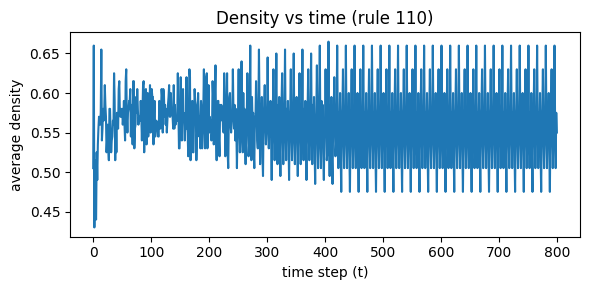

Saved: /mnt/c/Users/caeca/CSB195/src/py/ACA_outputs/density.png
Total fractional density over all cells and times: 0.5622222222222222


In [7]:

# ================================================================
# CELL 5: Analysis — density over time & total density
# ================================================================
import matplotlib.pyplot as plt

def density_per_step(world: World) -> np.ndarray:
    # mean of each row (fraction of '1's)
    return world.state.mean(axis=1)
    

def plot_density_vs_time(world: World, figsize=(6,3)):
    d = density_per_step(world)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.plot(np.arange(d.shape[0]), d, linewidth=1.5)
    ax.set_xlabel("time step (t)")
    ax.set_ylabel("average density")
    ax.set_title(f"Density vs time (rule {world.rule})")
    fig.tight_layout()
    # Save small figure next to HTML for convenience    
    out_png = Path("./ACA_outputs/density.png")
    fig.savefig(out_png, dpi=150)
    display(fig)
    plt.close(fig)
    print("Saved:", out_png.resolve())

def total_fractional_density(world: World) -> float:
    return float(world.state.mean())

plot_density_vs_time(world)
print("Total fractional density over all cells and times:", total_fractional_density(world))
